# Supervised setting: CVs as classifiers

## Setup

In [21]:
# IMPORT PACKAGES
import torch
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import subprocess

# IMPORT from MLCVS 
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics, paletteFessa
from mlcolvar.utils.trainer import MetricsCallback


# IMPORT utils functions fo input generation
from utils.generate_input import gen_input_md,gen_input_md_potential,gen_plumed 

# Set seed for reproducibility
torch.manual_seed(42)

# ============================ SIMULATIONS VARIABLES ================================
run_calculations = False

if run_calculations:
    # plumed setup
    PLUMED_SOURCE = '/home/etrizio@iit.local/Bin/dev/plumed2-dev/sourceme.sh'
    PLUMED_EXE = f'source {PLUMED_SOURCE} && plumed'
    PLUMED_VES_MD = f"{PLUMED_EXE} ves_md_linearexpansion < input_md.dat"

    #test plumed
    subprocess.run(f"{PLUMED_EXE}", shell=True, executable='/bin/bash')

### System: modified Muller Brown potential

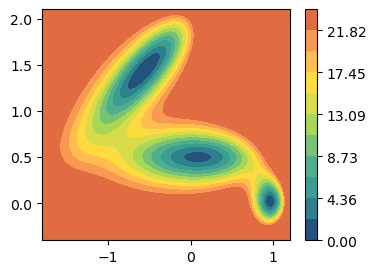

In [2]:
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax)
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

## Train a DeepTDA CV

In [3]:
from mlcolvar.cvs import DeepTDA

RESULTS_FOLDER = '../data/supervised'
# subprocess.run(f"rm -r {RESULTS_FOLDER}", shell=True)
# subprocess.run(f"mkdir {RESULTS_FOLDER}", shell=True)

### Load Data

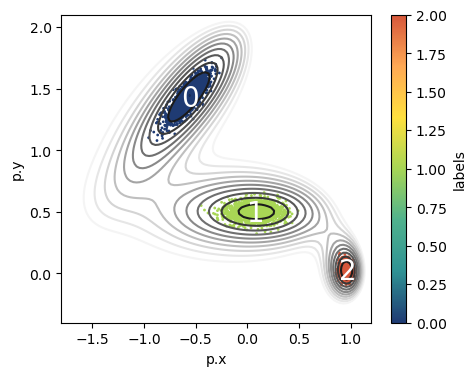

In [5]:
n_states = 3
filenames = [ f"../../data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, verbose=False)

# create datamodule for trainer
datamodule = DictModule(dataset,lengths=[0.8,0.2])


fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Define DeepTDA model

In [6]:
n_cvs = 1
target_centers = [-10,0,10]
target_sigmas = [0.2, 0.2, 0.2]
nn_layers = [2,32,16,1]
options = {'nn' : {'activation' : 'shifted_softplus'} }
# MODEL
if run_calculations:
    model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)
else:
    model = torch.jit.load(f'{RESULTS_FOLDER}/model_deepTDA.pt')

### Define Trainer & Fit

In [7]:
if run_calculations:
    # define callbacks
    metrics = MetricsCallback()
    early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-1, patience=10)

    # define trainer
    trainer = pl.Trainer(accelerator='cuda',callbacks=[metrics, early_stopping], max_epochs=10000,
                        enable_checkpointing=False, enable_model_summary=False)
    # fit
    trainer.fit( model, datamodule )
    traced_model = model.to_torchscript(file_path=f'{RESULTS_FOLDER}/model_deepTDA.pt', method='trace')


### Analysis of the CV

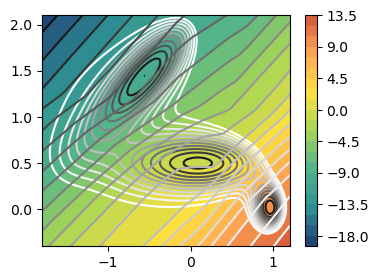

In [8]:
n_components = 1
fig,axs = plt.subplots( 1, n_components, figsize=(4*n_components,3) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

#plt.savefig(f'{RESULTS_FOLDER}/cv_isolines.png')
plt.show()


## Run PLUMED simulation

In [9]:
SIMULATION_FOLDER = f'{RESULTS_FOLDER}/data'

if run_calculations:
    # create folder
    #subprocess.run(f"mkdir {SIMULATION_FOLDER}", shell=True)

    # generate inputs
    gen_plumed(model_name=f'model_deepTDA.pt', 
            file_path=SIMULATION_FOLDER, 
            potential_formula=MULLER_BROWN_FORMULA, 
            opes_mode='OPES_METAD')
    gen_input_md(inital_position='-0.7,1.4', file_path=SIMULATION_FOLDER, nsteps=1000000)
    gen_input_md_potential(file_path=SIMULATION_FOLDER)

    subprocess.run(f'{PLUMED_EXE} ves_md_linearexpansion < input_md.dat', cwd=SIMULATION_FOLDER, shell=True, executable='/bin/bash')

### Visualize sampling

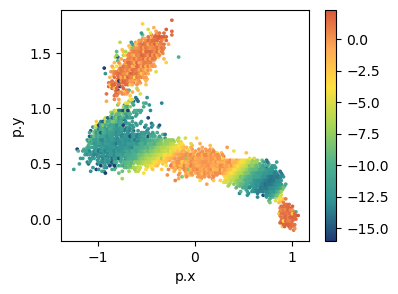

In [10]:
data = load_dataframe(f'{SIMULATION_FOLDER}/COLVAR')
fig, ax = plt.subplots(figsize=(4,3))
data.plot.hexbin('p.x', 'p.y', C='opes.bias',cmap='fessa', ax=ax)
#plt.savefig(f'{SIMULATION_FOLDER}/sampling.png')
plt.show()

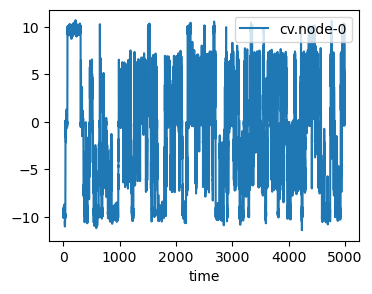

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
data.plot('time', 'cv.node-0', ax=ax)
plt.show()

## Analysis

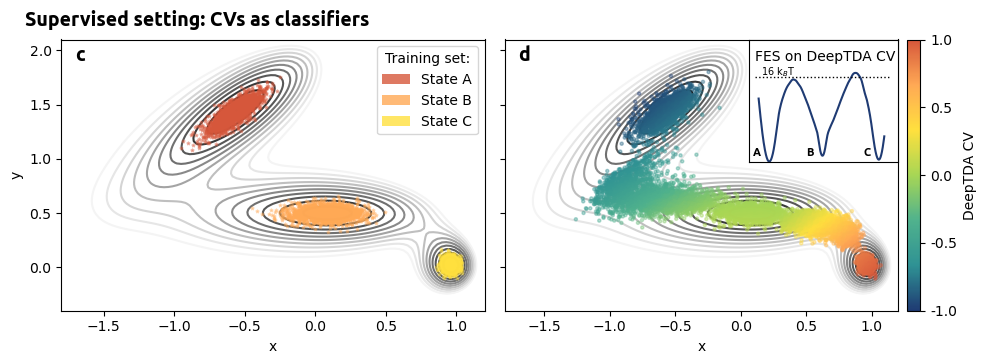

In [22]:
# load data
data = pd.DataFrame()
for i in range(0,3):
    temp = load_dataframe(f'../../data/muller-brown-3states/unbiased/state-{i}/COLVAR')
    temp['label'] = i
    data = pd.concat((data, temp), ignore_index=True)

# create figure
fig, axs = plt.subplots(1,2,figsize=(10,3.5))

# panel c
ax = axs[0]
ax.set_aspect('auto')

# plot fes 
plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour', zorder=0, ax=ax, alpha=1)
# plot data from different classes
for i in range(3):
    data_red = data.iloc[(data['label'] == i).values]
    cp = ax.scatter(data_red['p.x'],data_red['p.y'],c=paletteFessa[(-1-i)], marker='*', zorder=5, alpha=0.4, s=5)

# labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# visible legend 
proxy = [plt.Rectangle((0,0),1,1,fc = paletteFessa[-1], alpha=0.8), 
         plt.Rectangle((0,0),1,1,fc = paletteFessa[-2], alpha=0.8), 
         plt.Rectangle((0,0),1,1,fc = paletteFessa[-3], alpha=0.8) ]
ax.legend(proxy, ["State A", "State B", "State C"], title='Training set:', prop={'size': 10})


# panel d
ax = axs[1]
ax.set_aspect('auto')

# load data
data = load_dataframe(f'{RESULTS_FOLDER}/data/COLVAR')

# plot
plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour', zorder=0, ax=ax, alpha=1)
cp = ax.scatter(data['p.x'],data['p.y'],c=data['cv.node-0']/10,cmap='fessa', zorder=5, alpha=0.4, s=5)

# visble colormap
norm = mlp.colors.Normalize( vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm,cmap='fessa')
cbar = plt.colorbar(mappable=sm, fraction=0.050, pad=0.02, format='%.1f', ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
cbar.set_label('DeepTDA CV',fontsize=10)

# labels
ax.set_xlabel('x')
ax.yaxis.set_ticklabels([])

# FES inset
fes,bins,_,_ = compute_fes(data['cv.node-0'].values, kbt=1, plot=False, num_samples=1000, scale_by='range', weights=np.exp(data['opes.bias'].values))
ins = ax.inset_axes([0.62,0.55,0.38,0.45])
cp = ins.plot(bins/10,fes,color=paletteFessa[0],lw=1.5)
ins.hlines(16,-1.2,1.2, ls='dotted', lw=1, color='k')
ins.text(-1.1, 16.2, '16 k$_B$T', fontsize=7)#, font='ubuntu')

# label states
ins.text(-1.25, 1, 'A', fontsize=8, fontweight='demi', font='ubuntu')
ins.text(-0.3, 1, 'B', fontsize=8, fontweight='demi', font='ubuntu')
ins.text(0.7, 1, 'C', fontsize=8, fontweight='demi', font='ubuntu')

# labels and ticks
ins.yaxis.set_ticklabels([])
ins.yaxis.set_ticks([])
ins.xaxis.set_ticklabels([])
ins.xaxis.set_ticks([])
ins.set_ylim(0,23)
ins.text(-1.2, 19, 'FES on DeepTDA CV', fontsize=10, fontweight='medium')#, font='ubuntu')

# panels handles
fig.text(0.03, 0.98, 'Supervised setting: CVs as classifiers', fontsize=14, fontweight='demi', font='ubuntu')
axs[0].text(-1.7, 1.9, 'c', fontsize=14, fontweight='demi', font='ubuntu')
axs[1].text(-1.7, 1.9, 'd', fontsize=14, fontweight='demi', font='ubuntu')

plt.tight_layout()
#plt.savefig('muller_experiments/figures/examples_supervised.png', dpi=300, bbox_inches='tight')
plt.show()